X-RAY 사진 판독 폐렴 진단기를 만들어보는 실험입니다.

### 목차

- step 1. 실험환경 set up
- step 2. 데이터 준비하기
- step 3. 데이터 시각화
- step 4. ResNet-18 구현
- step 5. 데이터 imbalance 처리
- step 6. 모델 훈련
- step 7. 결과 확인과 시각화

## Step 1. 실험환경 Set-up

기본 값을 세팅하고 추후에 실험시에 함수의 parameter를 통해 변경가능하도록 진행했습니다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행시 변경해보아야할 하이퍼파라미터
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

좌우 반전 augment가 적용되어 있는 데이터셋 train_ds, val_ds와
적용되어있지 않은 데이터셋 train_ds_original, val_ds_original을 준비합니다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


파일 이름 확인하기 

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


파일 경로에 NORMAL이 있으면 정상 이미지, PNEUMONIA이 있으면 폐렴 이미지

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


normal 데이터와 pneumonia 데이터간 불균형 확인

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [63]:
train_ds_original = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_original = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

트레인 및 validation용 이미지 전처리가 잘 되었는지 확인

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


랜덤하게 좌우를 반전하는 로직 추가

In [61]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) 
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000, apply_augment=True):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    if apply_augment:
        ds = ds.map(
                augment,       # augment 함수 적용
                num_parallel_calls=2
            )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

결과 비교 차원에서 좌우반전을 하지 않은 original dataset 준비

In [64]:
train_ds_original = prepare_for_training(train_ds_original, 1000, False)
val_ds_original = prepare_for_training(val_ds_original, 1000, False)

## Step 3. 데이터 시각화

출력을 통해 좌우반전이 잘 적용되었는지 확인해봅니다.

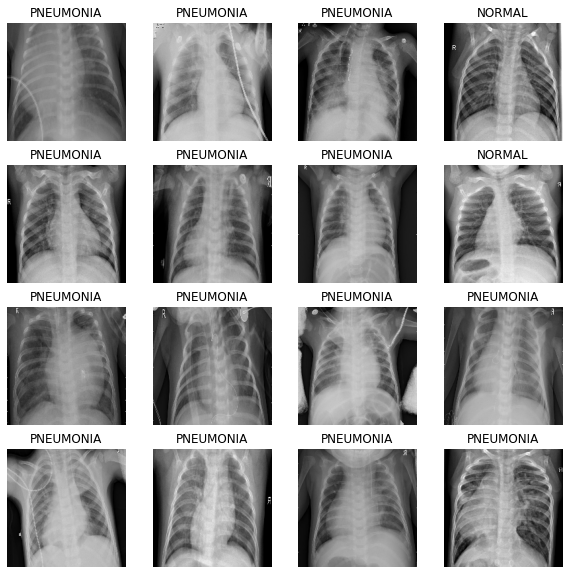

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

심장(?)이 랜덤하게 반대쪽에 있는 모습 확인 가능함. 원래는 아래와 같이 오른쪽으로 가있는것 같음

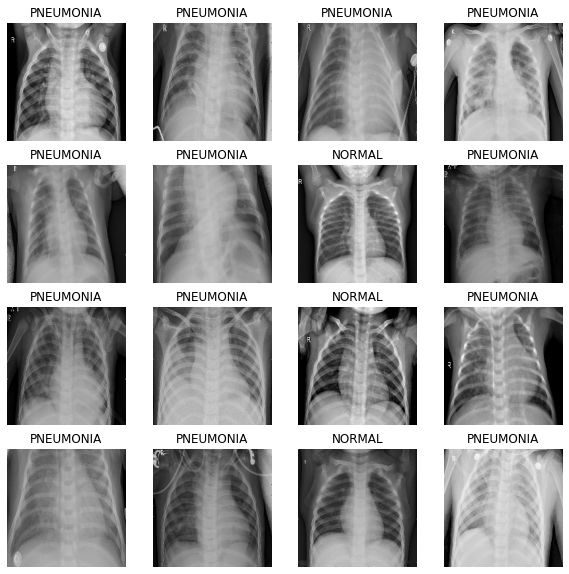

In [65]:
image_batch, label_batch = next(iter(train_ds_original))
show_batch(image_batch.numpy(), label_batch.numpy())

### 기존 모델 구현

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def base_cnn(dense_units=[512, 128, 64], dropouts=[0.2, 0.2, 0.7, 0.5, 0.3]):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(dropouts[0]),
        
        conv_block(256),
        tf.keras.layers.Dropout(dropouts[1]),
        
        tf.keras.layers.Flatten(),
        dense_block(dense_units[0], dropouts[2]),
        dense_block(dense_units[1], dropouts[3]),
        dense_block(dense_units[2], dropouts[4]),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

conv_layer는 그대로 두고 dense_units와 dropouts를 변경해가면서 실험하기 위해 조정.

## Step 4. ResNet-18 구현

더 자세한 내용이 없어서 아래 그림과 같은 모델을 구현하였습니다.

![](https://learnopencv.com/wp-content/uploads/2020/03/resnet-18-265x1024.png)

In [124]:
def residual_block(x, filters, has_pool = False):
    stride = 2 if has_pool else 1
    
    fx = tf.keras.layers.Conv2D(filters, 3, stride, padding="same")(x)
    fx = tf.keras.layers.BatchNormalization(use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5)(fx)
    fx = tf.keras.layers.ReLU()(fx)
    fx = tf.keras.layers.Conv2D(filters, 3, 1, padding="same")(fx)
    fx = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.9)(fx)
    
    if has_pool:
        x = tf.keras.layers.Conv2D(filters, 3, stride, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
    
    output = tf.keras.layers.Add()([fx, x]) # fx + x
    output = tf.keras.layers.ReLU()(output)
    return output    

In [125]:
def resnet18():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    # conv1
    x = tf.keras.layers.Conv2D(64, 7, 2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # conv2_x
    x = tf.keras.layers.MaxPooling2D((3, 3), 2)(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # conv3_x
    x = residual_block(x, 128, True)
    x = residual_block(x, 128)
    
    # conv4_x
    x = residual_block(x, 256, True)
    x = residual_block(x, 256)
    
    # conv5_x
    x = residual_block(x, 512, True)
    x = residual_block(x, 512)
    
    # average_pool
    x = tf.keras.layers.AveragePooling2D((6, 6))(x)
    x = tf.keras.layers.Reshape((-1,))(x)
    
    # fullyconnected 
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

구현이 올바르게 되었는지 확인하기

In [126]:
model_resnet = resnet18()
model_resnet.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_306 (Conv2D)             (None, 90, 90, 64)   9472        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_409 (BatchN (None, 90, 90, 64)   256         conv2d_306[0][0]                 
__________________________________________________________________________________________________
re_lu_302 (ReLU)                (None, 90, 90, 64)   0           batch_normalization_409[0][0]    
___________________________________________________________________________________________

## Step 5. 데이터 imbalance 처리

Normal 데이터는 1070개, Pneumonia 데이터는 3115개로 약 3배 정도의 차이가 났음.
이경우 데이터가 imbalance 하다고 판단하여 wegith balancing을 적용.
imbalance 할 경우 학습효과가 좋지 않을 수 있음.

In [38]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

재사용을 위해 build_model함수와 train_model 재구성

In [24]:
def build_model(model_func, optimizer='adam'):
    with tf.device('/GPU:0'):
        model = model_func()

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=METRICS
        )
    return model

In [66]:
def train_model(model, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                class_weight=CLASS_WEIGHT, 
                train_data=train_ds,
                validation_data=val_ds):
    with tf.device('/GPU:0'):
        history = model.fit(
            train_data,
            steps_per_epoch=TRAIN_IMG_COUNT // batch_size,
            epochs=epochs,
            validation_data=validation_data,
            validation_steps=VAL_IMG_COUNT // batch_size,
            class_weight=class_weight,
        )
    return history

### Base CNN

cnn model 0: 노드 기본 모델 및 훈련 방법 적용, 좌우 반전 되지 않은 이미지 사용

In [93]:
model_cnn_0_name = "Base CNN(e=10, b=16, o=adam) original"
model_cnn_0 = build_model(base_cnn)
history_cnn_0 = train_model(model_cnn_0, train_data=train_ds_original, validation_data=val_ds_original)

Epoch 1/10
261/261 [==============================] - 60s 197ms/step - loss: 0.3863 - accuracy: 0.8039 - precision: 0.9493 - recall: 0.7779 - val_loss: 0.7077 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 198ms/step - loss: 0.2229 - accuracy: 0.9152 - precision: 0.9749 - recall: 0.9097 - val_loss: 1.2620 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1905 - accuracy: 0.9334 - precision: 0.9771 - recall: 0.9325 - val_loss: 0.5096 - val_accuracy: 0.7750 - val_precision: 0.7653 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 201ms/step - loss: 0.1750 - accuracy: 0.9358 - precision: 0.9807 - recall: 0.9320 - val_loss: 0.4930 - val_accuracy: 0.7856 - val_precision: 0.7738 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 53s 202ms/step - loss: 0.1521 - accura

cnn model 1: 노드 기본 모델 및 훈련 방법 적용, 좌우반전 이미지 사용

In [94]:
model_cnn_1_name = "Base CNN(e=10, b=16, o=adam)"
model_cnn_1 = build_model(base_cnn)
history_cnn_1 = train_model(model_cnn_1)

Epoch 1/10
261/261 [==============================] - 63s 204ms/step - loss: 0.3878 - accuracy: 0.8041 - precision: 0.9497 - recall: 0.7779 - val_loss: 0.6973 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 196ms/step - loss: 0.2364 - accuracy: 0.9083 - precision: 0.9736 - recall: 0.9013 - val_loss: 1.1310 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 203ms/step - loss: 0.2303 - accuracy: 0.9159 - precision: 0.9726 - recall: 0.9128 - val_loss: 0.5691 - val_accuracy: 0.7471 - val_precision: 0.7434 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 201ms/step - loss: 0.1722 - accuracy: 0.9325 - precision: 0.9793 - recall: 0.9290 - val_loss: 0.0817 - val_accuracy: 0.9654 - val_precision: 0.9739 - val_recall: 0.9790
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1853 - accura

cnn model 2: 노드 기본 모델 및 epoch 20회, batch size 64, 좌우반전 이미지 사용

In [31]:
model_cnn_2_name = "Base CNN(e=20, b=64, o=adam)"
model_cnn_2 = build_model(base_cnn)
history_cnn_2 = train_model(model_cnn_2, epochs=20, batch_size=64)

Epoch 1/20
65/65 [==============================] - 29s 300ms/step - loss: 0.6840 - accuracy: 0.6221 - precision: 0.8627 - recall: 0.5931 - val_loss: 0.7512 - val_accuracy: 0.2227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
65/65 [==============================] - 19s 295ms/step - loss: 0.4481 - accuracy: 0.7798 - precision: 0.9356 - recall: 0.7545 - val_loss: 0.6339 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 19s 291ms/step - loss: 0.3031 - accuracy: 0.8596 - precision: 0.9786 - recall: 0.8290 - val_loss: 0.6103 - val_accuracy: 0.7109 - val_precision: 0.7109 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 19s 300ms/step - loss: 0.2695 - accuracy: 0.8865 - precision: 0.9685 - recall: 0.8756 - val_loss: 0.6775 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 19s 303ms/step - loss: 0.2631 - accuracy

cnn model 3: 노드 기본 모델 및 epoch 10회, batch size 16, sgd optimizer 사용, 좌우반전 이미지 사용

In [33]:
model_cnn_3_name = "Base CNN(e=10, b=16, o=sgd)"
model_cnn_3 = build_model(base_cnn, optimizer="sgd")
history_cnn_3 = train_model(model_cnn_3)

Epoch 1/10
261/261 [==============================] - 60s 196ms/step - loss: 0.8439 - accuracy: 0.5048 - precision: 0.7474 - recall: 0.5061 - val_loss: 0.7056 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
261/261 [==============================] - 51s 195ms/step - loss: 0.7391 - accuracy: 0.5029 - precision: 0.7451 - recall: 0.5043 - val_loss: 0.6510 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.00000.7467 - recal
Epoch 3/10
261/261 [==============================] - 51s 195ms/step - loss: 0.7150 - accuracy: 0.4909 - precision: 0.7370 - recall: 0.4913 - val_loss: 0.7247 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.6944 - accuracy: 0.5055 - precision: 0.7595 - recall: 0.4908 - val_loss: 0.7148 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
261/261 [==============================] - 

cnn model 4: 노드 기본 모델 및 learning rate 0.01로 변경, 좌우반전 이미지 사용

In [34]:
model_cnn_4_name = "Base CNN(e=10, b=16, o=adam, lr=0.01)"
model_cnn_4 = build_model(base_cnn, optimizer=tf.keras.optimizers.Adam(0.01))
history_cnn_4 = train_model(model_cnn_4)

Epoch 1/10
261/261 [==============================] - 60s 196ms/step - loss: 0.4778 - accuracy: 0.7864 - precision: 0.9188 - recall: 0.7822 - val_loss: 4.2882 - val_accuracy: 0.7423 - val_precision: 0.7408 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 194ms/step - loss: 0.3092 - accuracy: 0.8678 - precision: 0.9584 - recall: 0.8597 - val_loss: 0.3151 - val_accuracy: 0.8779 - val_precision: 0.9833 - val_recall: 0.8478
Epoch 3/10
261/261 [==============================] - 51s 195ms/step - loss: 0.2594 - accuracy: 0.8915 - precision: 0.9660 - recall: 0.8855 - val_loss: 1.0184 - val_accuracy: 0.7077 - val_precision: 0.9957 - val_recall: 0.6037
Epoch 4/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2147 - accuracy: 0.9140 - precision: 0.9784 - recall: 0.9044 - val_loss: 0.2668 - val_accuracy: 0.8865 - val_precision: 0.9820 - val_recall: 0.8609
Epoch 5/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2025 - accura

cnn model 5: 노드 기본 모델 및 class weight 미적용, 좌우반전 이미지 사용

In [40]:
model_cnn_5_name = "Base CNN(e=10, b=16, o=adam, cw=None)"
model_cnn_5 = build_model(base_cnn)
history_cnn_5 = train_model(model_cnn_5, class_weight=None)

Epoch 1/10
261/261 [==============================] - 59s 196ms/step - loss: 0.4308 - accuracy: 0.8192 - precision: 0.9194 - recall: 0.8297 - val_loss: 0.7510 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 195ms/step - loss: 0.2612 - accuracy: 0.9021 - precision: 0.9330 - recall: 0.9357 - val_loss: 1.0269 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 197ms/step - loss: 0.1944 - accuracy: 0.9241 - precision: 0.9471 - recall: 0.9511 - val_loss: 1.5486 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1961 - accuracy: 0.9298 - precision: 0.9516 - recall: 0.9543 - val_loss: 0.1527 - val_accuracy: 0.9327 - val_precision: 0.9220 - val_recall: 0.9921
Epoch 5/10
261/261 [==============================] - 52s 198ms/step - loss: 0.1663 - accura

### ResNet18

ResNet18 좌우반전 없는 데이터로 학습 (epoch 10, batch_size 16, adam default)

In [105]:
model_res_0_name = "ResNet18(e=10, b=16, o=adam, original)"
model_res_0 = build_model(resnet18)
history_res_0 = train_model(model_res_0, train_data=train_ds_original, validation_data=val_ds_original)

Epoch 1/10
261/261 [==============================] - 60s 194ms/step - loss: 0.3225 - accuracy: 0.8834 - precision: 0.9561 - recall: 0.8838 - val_loss: 3.9048 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2240 - accuracy: 0.9162 - precision: 0.9726 - recall: 0.9131 - val_loss: 1.0900 - val_accuracy: 0.4635 - val_precision: 0.9951 - val_recall: 0.2690
Epoch 3/10
261/261 [==============================] - 50s 194ms/step - loss: 0.1771 - accuracy: 0.9327 - precision: 0.9780 - recall: 0.9305 - val_loss: 0.7920 - val_accuracy: 0.6740 - val_precision: 0.9930 - val_recall: 0.5596
Epoch 4/10
261/261 [==============================] - 51s 197ms/step - loss: 0.1396 - accuracy: 0.9495 - precision: 0.9862 - recall: 0.9453 - val_loss: 7.7614 - val_accuracy: 0.2769 - val_precision: 1.0000 - val_recall: 0.0144
Epoch 5/10
261/261 [==============================] - 52s 201ms/step - loss: 0.1374 - accura

ResNet18 좌우반전 있는 데이터로 학습 (epoch 10, batch_size 16, adam default)

In [106]:
model_res_1_name = "ResNet18(e=10, b=16, o=adam)"
model_res_1 = build_model(resnet18)
history_res_1 = train_model(model_res_1)

Epoch 1/10
261/261 [==============================] - 63s 200ms/step - loss: 0.3554 - accuracy: 0.8669 - precision: 0.9567 - recall: 0.8601 - val_loss: 4.3018 - val_accuracy: 0.7365 - val_precision: 0.7360 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2257 - accuracy: 0.9025 - precision: 0.9714 - recall: 0.8954 - val_loss: 8.2995 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
261/261 [==============================] - 50s 194ms/step - loss: 0.1690 - accuracy: 0.9320 - precision: 0.9773 - recall: 0.9301 - val_loss: 0.1940 - val_accuracy: 0.9404 - val_precision: 0.9333 - val_recall: 0.9895
Epoch 4/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1819 - accuracy: 0.9291 - precision: 0.9782 - recall: 0.9253 - val_loss: 0.2395 - val_accuracy: 0.9115 - val_precision: 0.8950 - val_recall: 0.9961
Epoch 5/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1382 

In [119]:
train_model(model_res_1, epochs=1)

261/261 [==============================] - 57s 193ms/step - loss: 0.0780 - accuracy: 0.9665 - precision: 0.9911 - recall: 0.9636 - val_loss: 0.0931 - val_accuracy: 0.9635 - val_precision: 0.9814 - val_recall: 0.9685


## Step 7. 결과 확인과 시각화

In [41]:
def print_train_history(history, model_name):
    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} Model {}'.format(model_name, met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.show()

In [42]:
def evaluate_model(model):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### 노드 기본  cnn  적용 결과

In [83]:
base_cnn_names = [
    model_cnn_0_name,
    model_cnn_1_name,
    model_cnn_2_name,
    model_cnn_3_name,
    model_cnn_4_name,
    model_cnn_5_name,
]
base_cnn_models = [
    model_cnn_0,
    model_cnn_1, 
    model_cnn_2, 
    model_cnn_3, 
    model_cnn_4,
    model_cnn_5,
]
base_cnn_histories = [
    history_cnn_0,
    history_cnn_1, 
    history_cnn_2, 
    history_cnn_3, 
    history_cnn_4, 
    history_cnn_5,
]

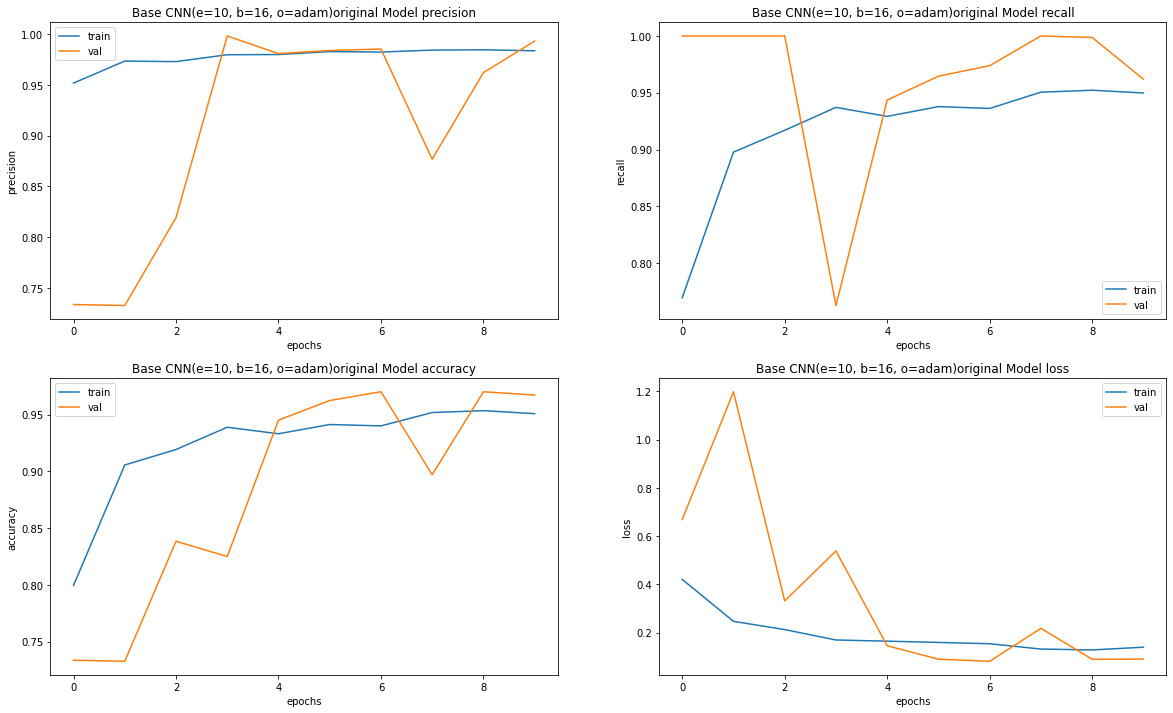

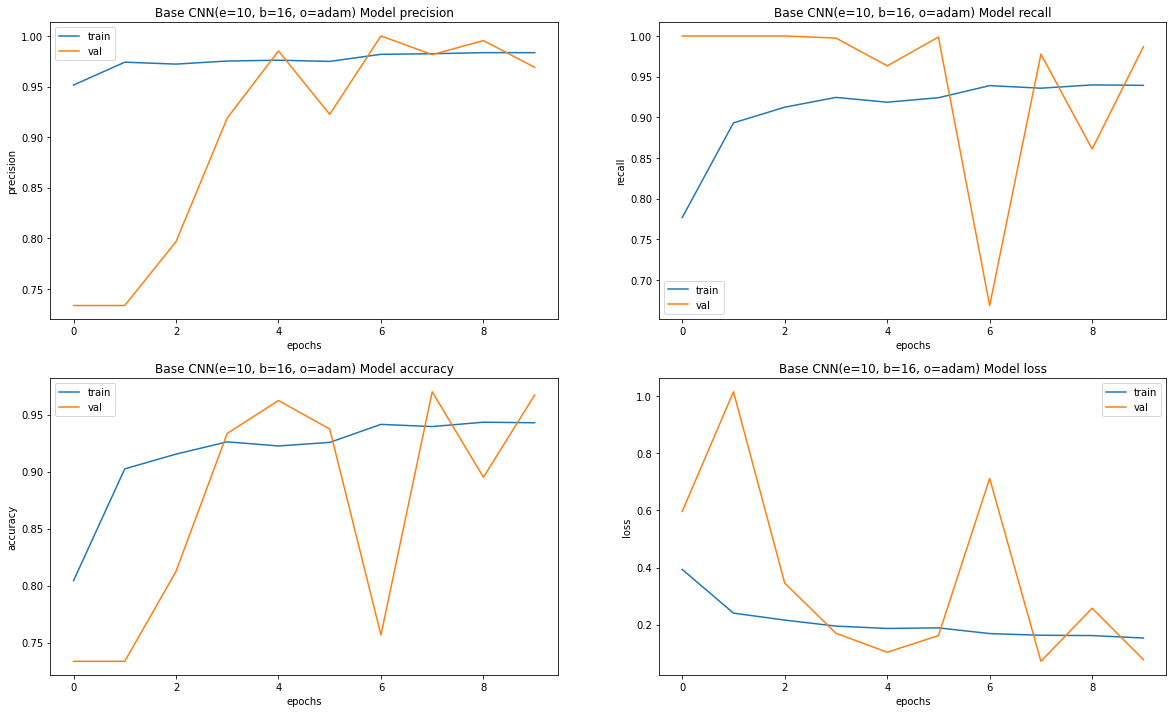

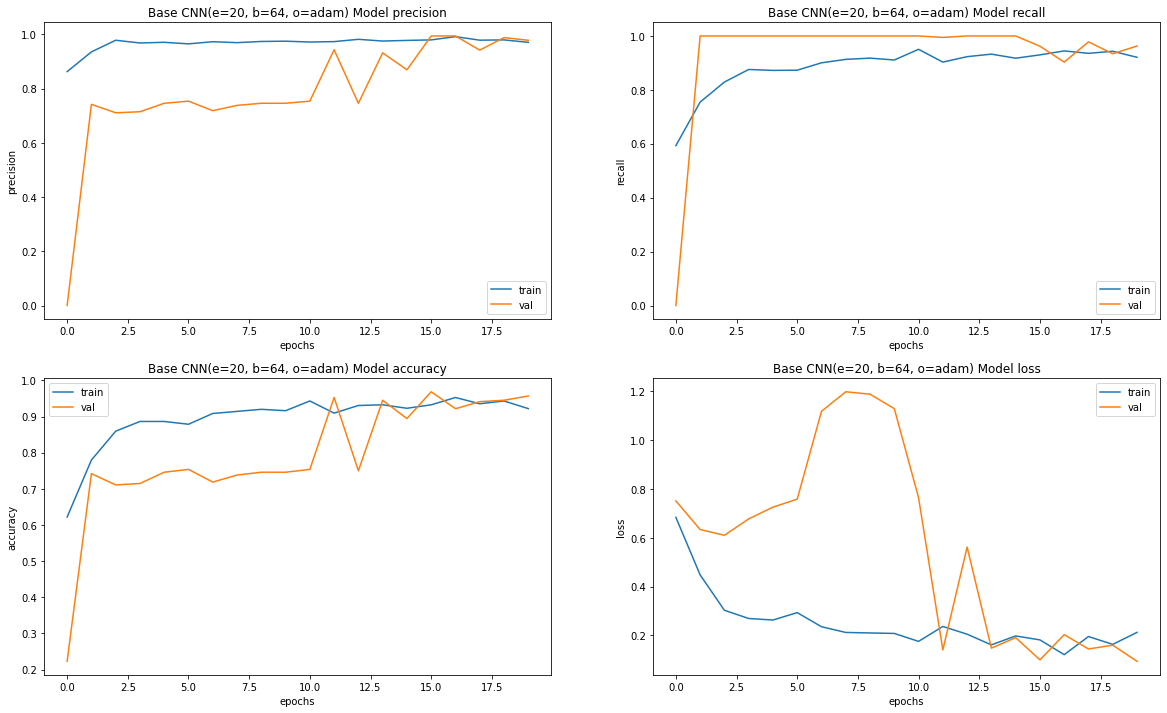

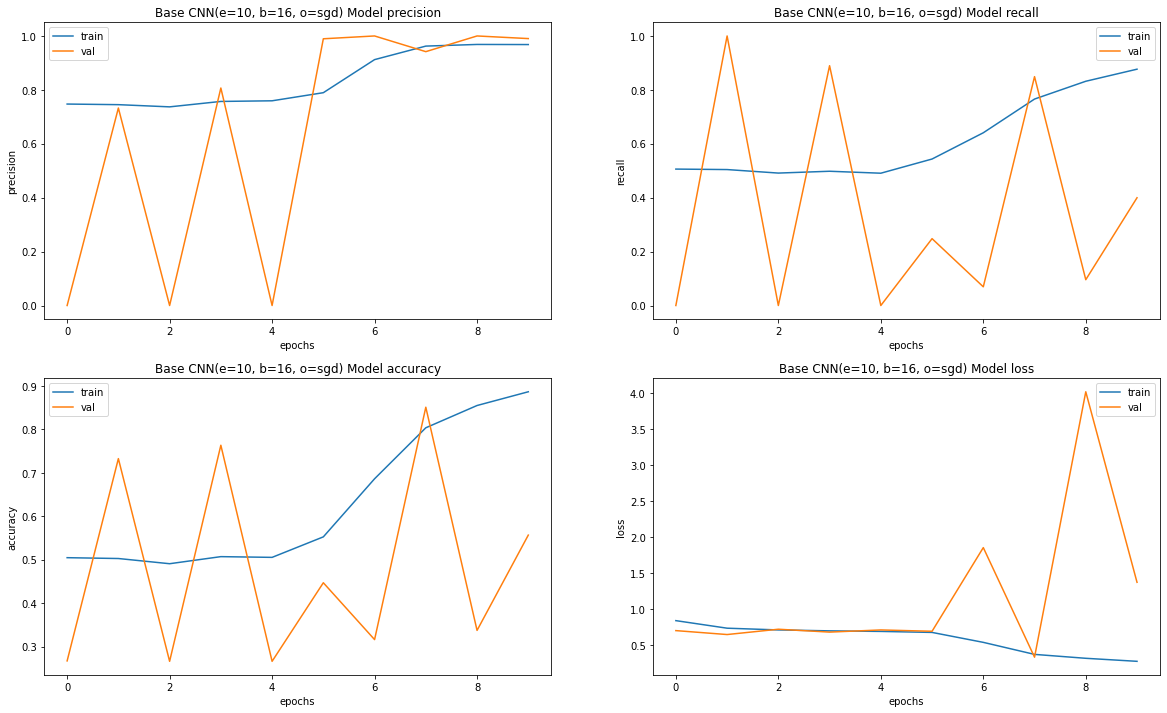

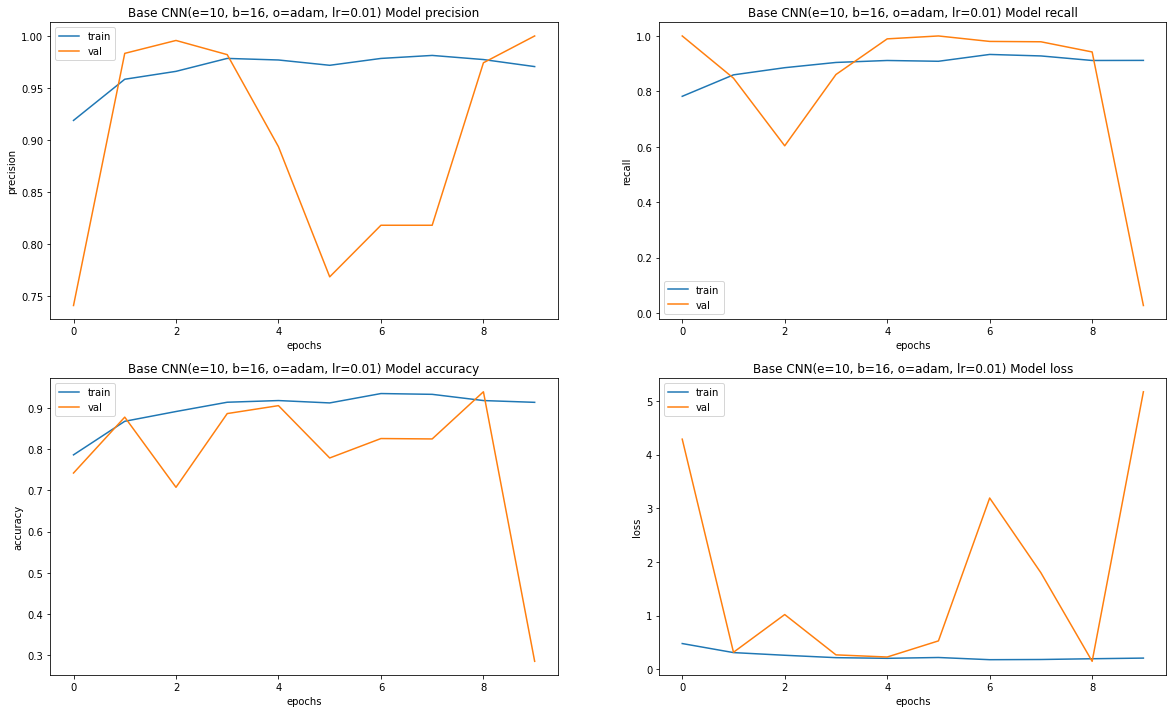

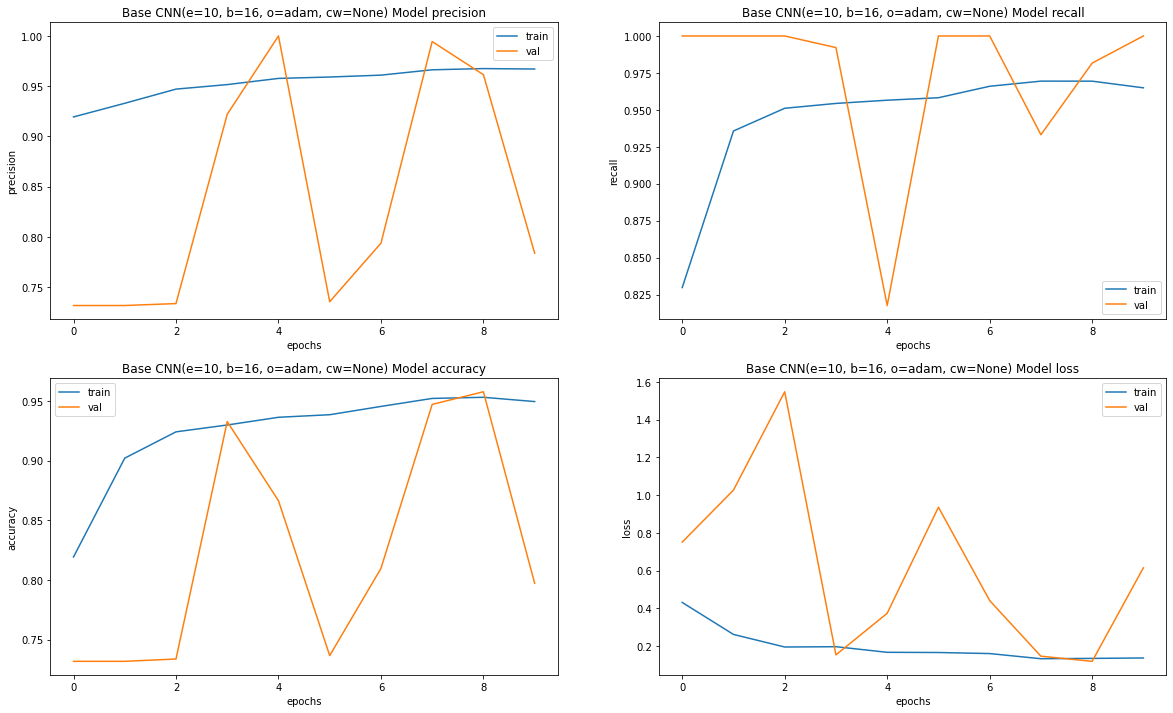

In [103]:
for name, history in zip(base_cnn_names, base_cnn_histories):
    print_train_history(history, name)

In [104]:
for idx, (name, model) in enumerate(zip(base_cnn_names, base_cnn_models)):
    print(f"model {idx}: {name}")
    evaluate_model(model)
    print("============\n")

model 0: Base CNN(e=10, b=16, o=adam)original
39/39 [==============================] - 5s 130ms/step - loss: 0.7618 - accuracy: 0.7821 - precision: 0.7490 - recall: 0.9795
Loss: 0.7617863416671753,
Accuracy: 0.7820512652397156,
Precision: 0.7490196228027344,
Recall: 0.9794871807098389

model 1: Base CNN(e=10, b=16, o=adam)
39/39 [==============================] - 5s 116ms/step - loss: 0.8674 - accuracy: 0.7388 - precision: 0.7067 - recall: 0.9949
Loss: 0.86735600233078,
Accuracy: 0.7387820482254028,
Precision: 0.7067395448684692,
Recall: 0.9948717951774597

model 2: Base CNN(e=20, b=64, o=adam)
39/39 [==============================] - 4s 108ms/step - loss: 0.5614 - accuracy: 0.7981 - precision: 0.7598 - recall: 0.9897
Loss: 0.5614018440246582,
Accuracy: 0.7980769276618958,
Precision: 0.7598425149917603,
Recall: 0.9897435903549194

model 3: Base CNN(e=10, b=16, o=sgd)
39/39 [==============================] - 5s 126ms/step - loss: 1.1455 - accuracy: 0.6330 - precision: 0.9548 - recall: 0

먼저 좌우반전을 적용한 이미지(model 1)와 반전하지 않은 이미지(model 0)의 결과를 비교하면,
model 0가 accuracy와 percision에서 우세하다. 하지만 recall은 1.5프로정도 떨어진 수치를 볼 수 있다.

model 1과 model 2는 같은 모델을 epoch과 batch_size를 변경하면서 실험하였다.
batch_size를 64로 늘리면서 1 epoch당 학습속도가 많이 빨라졌다. 따라서 epoch을 2배 늘려서 실험해보았다. 
특히 위쪽의 history 그래프를 찍어보았을때 model 2가 더 안정적인 학습이 이뤄지고 있다는 생각이 든다.
또한 결과 역시 더 좋은 결과를 내었다. 

model 3은 optimizer를 adam에서 sgd로 변경해 보았다.
loss의 감소폭이 adam에 비해 느려서 학습이 되려면 시간이 더 걸릴것 같다.
학습은 이루어지고 있지만 시간이 느리다.


model 4는 adam optimizer의 학습률을 기본값인 0.001 대신 0.01로 설정해서 돌려보았다.
loss가 최저점을 찾지 못하고 줄었다 늘었다 하는 모습을 확인할 수 있었다.
학습이 제대로 이루어지지 못한 모습니다.

model 5는 class weight를 미적용해 보았다. 이경우에 recall은 1이였지만 accuracy가 63.6% 밖에 되지 못했다. 
class weight를 적용한 결과가 낫다는 점을 확인할 수 있었다.


__기본적인 cnn실험시에는 model 0를 제외하고 전부 좌우 반전이 있는 이미지 데이터셋을 사용했음__

### ResNet18 적용 결과

In [107]:
resnet_names = [
    model_res_0_name,
    model_res_1_name,
#     model_res_2_name,
]
resnet_models = [
    model_res_0,
    model_res_1,
#     model_res_2,
]
resnet_histories = [
    history_res_0,
    history_res_1, 
#     history_res_2,
]

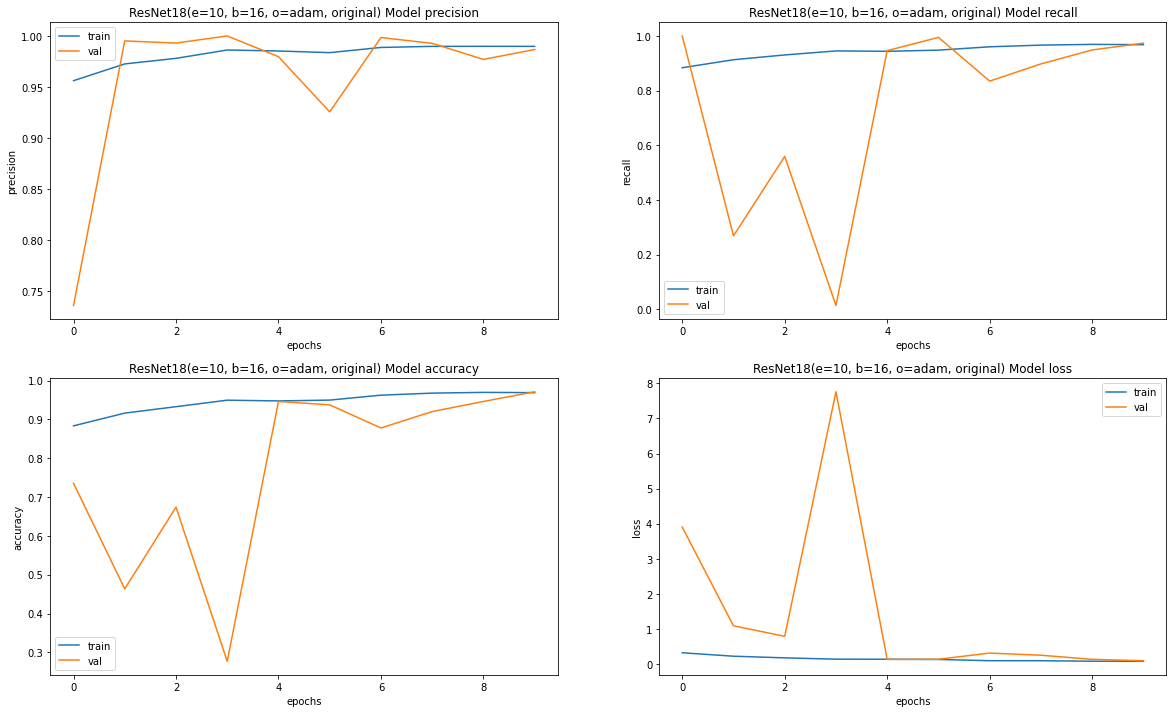

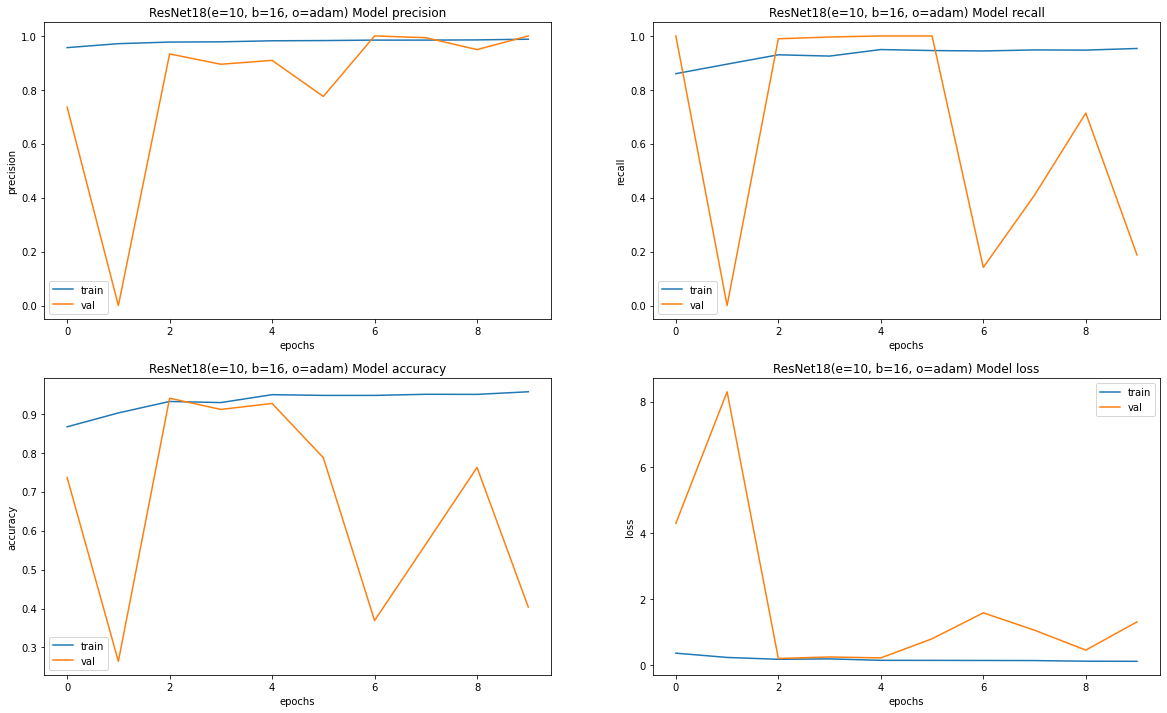

In [108]:
for name, history in zip(resnet_names, resnet_histories):
    print_train_history(history, name)

In [120]:
for idx, (name, model) in enumerate(zip(resnet_names, resnet_models)):
    print(f"model {idx}: {name}")
    evaluate_model(model)
    print("============\n")

model 0: ResNet18(e=10, b=16, o=adam, original)
39/39 [==============================] - 5s 119ms/step - loss: 0.7169 - accuracy: 0.7740 - precision: 0.7380 - recall: 0.9897
Loss: 0.7169133424758911,
Accuracy: 0.7740384340286255,
Precision: 0.7380496859550476,
Recall: 0.9897435903549194

model 1: ResNet18(e=10, b=16, o=adam)
39/39 [==============================] - 4s 113ms/step - loss: 0.7735 - accuracy: 0.8029 - precision: 0.7675 - recall: 0.9821
Loss: 0.7735010981559753,
Accuracy: 0.8028846383094788,
Precision: 0.7675350904464722,
Recall: 0.9820512533187866



여기에서는 오히려 좌우반전이 있는 모델이 더 좋은 결과를 냈음이 보여진다. 이전보다 validation data에 대한 지표가 수렴하지 못하고 요동치는 모습을 보여준다.

In [131]:
evaluate_model(model_res_1)

39/39 [==============================] - 4s 108ms/step - loss: 0.7735 - accuracy: 0.8029 - precision: 0.7675 - recall: 0.9821
Loss: 0.7735011577606201,
Accuracy: 0.8028846383094788,
Precision: 0.7675350904464722,
Recall: 0.9820512533187866


In [132]:
model_cnn_7_name = "Base CNN(e=50, b=64, o=adam)"
model_cnn_7 = build_model(base_cnn)
history_cnn_7 = train_model(model_cnn_7, epochs=50, batch_size=64)

Epoch 1/50
65/65 [==============================] - 29s 300ms/step - loss: 0.6945 - accuracy: 0.6183 - precision: 0.8525 - recall: 0.5817 - val_loss: 0.8052 - val_accuracy: 0.2656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
65/65 [==============================] - 19s 294ms/step - loss: 0.4263 - accuracy: 0.7683 - precision: 0.9632 - recall: 0.7143 - val_loss: 0.6509 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 18s 283ms/step - loss: 0.3691 - accuracy: 0.8394 - precision: 0.9744 - recall: 0.8118 - val_loss: 0.5762 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 19s 300ms/step - loss: 0.3293 - accuracy: 0.8673 - precision: 0.9551 - recall: 0.8603 - val_loss: 0.5729 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 20s 310ms/step - loss: 0.3167 - accuracy

65/65 [==============================] - 19s 288ms/step - loss: 0.1857 - accuracy: 0.9404 - precision: 0.9789 - recall: 0.9416 - val_loss: 0.3465 - val_accuracy: 0.8789 - val_precision: 1.0000 - val_recall: 0.8385
Epoch 38/50
65/65 [==============================] - 17s 270ms/step - loss: 0.1592 - accuracy: 0.9337 - precision: 0.9832 - recall: 0.9251 - val_loss: 0.1077 - val_accuracy: 0.9727 - val_precision: 0.9788 - val_recall: 0.9840
Epoch 39/50
65/65 [==============================] - 18s 278ms/step - loss: 0.1570 - accuracy: 0.9375 - precision: 0.9822 - recall: 0.9325 - val_loss: 0.0905 - val_accuracy: 0.9609 - val_precision: 1.0000 - val_recall: 0.9448
Epoch 40/50
65/65 [==============================] - 18s 281ms/step - loss: 0.0862 - accuracy: 0.9683 - precision: 0.9946 - recall: 0.9623 - val_loss: 0.0657 - val_accuracy: 0.9805 - val_precision: 0.9793 - val_recall: 0.9947
Epoch 41/50
65/65 [==============================] - 18s 287ms/step - loss: 0.1480 - accuracy: 0.9423 - prec

In [133]:
evaluate_model(model_cnn_7)

39/39 [==============================] - 5s 126ms/step - loss: 0.4883 - accuracy: 0.8365 - precision: 0.8243 - recall: 0.9385
Loss: 0.4883193373680115,
Accuracy: 0.8365384340286255,
Precision: 0.8243243098258972,
Recall: 0.9384615421295166


## 회고

다양한 하이퍼 파라미터 및 데이터를 교체해가며 실험을 진행해 보았다.
내 실험결과로는 좌우로 뒤집혀진 데이터가 있냐 없느냐의 우월성(?)이 ResNet과 일반 CNN에서 반대로 나와 신기하다.
사실 심장은 왼쪽에 있으니까(사진에서는 오른쪽으로 찍히는 것으로 보임) 희귀병이 있는경우를 제외하고는 좌우를 뒤집는게 의미가 있을까 싶으면서도
ResNet의 결과를 보니 어떻게든 data augmentation을 진행하는 쪽이 나은것 같기도하다.

생각보다 하이퍼파라미터를 변경해보았을떄 결과가 썩 좋지는 못했다. 

ResNet 18 모델의 구조를 짤때 여러 레이어에서의 하이퍼파라미터를 고려하지 못하고 짜게 되었는데 
이점이 ResNet의 history 지표에 반영이 된게 아닌가 싶다.
예전 노드에서의 기억으로는 l2 regularization 같은게 있었던 것 같은데 그런걸 적용하면 조금더 나은 결과가 나오지 않았을까 싶기도 하다.
